# Mask Detection Classification

In this section of the 2nd project we are tasked to classify images of people wearing masks. This specific dataset contains 853 images of 3 classes:
* People wearing masks (Identifier: 'with_mask')
* People not wearing masks (Identifier: 'without_mask')
* People wearing masks incorrectly (Identifier: 'mask_weared_incorrect')

We will develop a neural network using the keras python library to classify unknown images to one of the 3 classes.


The dataset is comprised of pairs of images - annotations (XML files). For each image, its corresponding XML file is used to crop the image into smaller images that contain the head area of approximately every person in the image. The cropping is performed by x and y values in the XML file which form a rectangle in the original image. For each crop rectangle, the output label ('with_mask', 'without_mask', 'mask_weared_incorrect') is provided. Thus, multiple smaller labeled images are generated from the original 883 images which will become the datasets we will use later in the training phase.


The first step is to download the dataset from kaggle using our credentials and extract the images and annotations into separate folders.

In [ ]:
# Global library imports

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import xml.etree.ElementTree as ET 
import pandas as pd
from tensorflow.keras import layers as l
from tensorflow.keras import models as m
import tensorflow as tf
from sklearn.model_selection import KFold

In [ ]:
! mkdir ~/.kaggle # create the .kaggle folder in the root directory
! echo '{"username":"vasiliskal","key":"cfc54686815d88fdfebb07db8aeb5f62"}' > ~/.kaggle/kaggle.json # write kaggle API credentials to kaggle.json
! chmod 600 ~/.kaggle/kaggle.json  # set permissions
! pip install kaggle # install the kaggle library

In [ ]:
! kaggle datasets download -d andrewmvd/face-mask-detection -p /content/kaggle/

 99% 395M/398M [00:03<00:00, 171MB/s]
100% 398M/398M [00:03<00:00, 136MB/s]


In [ ]:
%cd kaggle
! unzip face-mask-detection.zip

/content/kaggle
Archive:  face-mask-detection.zip
  inflating: annotations/maksssksksss0.xml  
  inflating: annotations/maksssksksss1.xml  
  inflating: annotations/maksssksksss10.xml  
  inflating: annotations/maksssksksss100.xml  
  inflating: annotations/maksssksksss101.xml  
  inflating: annotations/maksssksksss102.xml  
  inflating: annotations/maksssksksss103.xml  
  inflating: annotations/maksssksksss104.xml  
  inflating: annotations/maksssksksss105.xml  
  inflating: annotations/maksssksksss106.xml  
  inflating: annotations/maksssksksss107.xml  
  inflating: annotations/maksssksksss108.xml  
  inflating: annotations/maksssksksss109.xml  
  inflating: annotations/maksssksksss11.xml  
  inflating: annotations/maksssksksss110.xml  
  inflating: annotations/maksssksksss111.xml  
  inflating: annotations/maksssksksss112.xml  
  inflating: annotations/maksssksksss113.xml  
  inflating: annotations/maksssksksss114.xml  
  inflating: annotations/maksssksksss115.xml  
  inflating: ann

# Preprocessing

To be able to train the network, we need to follow a few preprocessing steps, especially with the existence of the annotation files.
The steps we will follow can be summarized as:
* Load images from ./images/ folder into a vector.
* Parse the XML annotations files from the ./annotations/ folder and create a dataframe, in which for each cropped image are logged the following. For the parsing we will use the xml.etree.ElementTree Python library.
  * The original filename of the image (*orig_name.png*)
  * The filename of the candidate cropped image (*orig_name_index.png*) where index=00,01,02..: the index of the cropped image with respect to the other cropped images from the same original image
  * xmin, xman, ymin, ymax. In order to crop the original image, a rectangle will be formed which will be defined by the points (xmin, ymin), (xmax,ymax). The x distance is defined as the width of the image, the y distance is defined as the height of the image and the origin point (0,0) is the upper left corner of the image.
  * The label for each cropped image ('with_mask', 'without_mask', 'mask_weared_incorrect').
* For each original image in the dataset, find its corresponding candidate cropped images from the dataframe, generate the cropped images and save them in the ./cropped/ folder.


In [ ]:
def get_images(input_imgs_dir, convert=False):
    """
      Loads all images and image paths from the input_imgs_dir directory into a vector.
    """ 

    input_imgs_paths = sorted([input_imgs_dir + fname for fname in os.listdir(input_imgs_dir)])

    x = []

    for img_path in input_imgs_paths:
      #x.append(img_to_array(load_img(img, target_size=img_size)))

      img = cv2.imread(img_path)

     
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      height, width, channels = img.shape
      #print(height, width, channels)
      x.append((img, img_path))
     
    return x

In [ ]:
def parseXMLs(xmls_dir):
  """ 
  Parses all the XML files in the xmls_dir directory. For each XML file corresponding to an original image in the dataset, we will keep:
    * The original image filename.
    * The cropped image filename.
    * xmin, xman, ymin, ymax to be able to find the rectangle used to crop the image
    * The label of the cropped image.
  Returns a dataframe containing these values.
  """

  original_filenames = []
  cropped_filenames = []

  xmins = []
  xmaxs = []
  ymins = []
  ymaxs = []
  labels = []

  for xml_file in sorted(os.listdir(xmls_dir)):
    #print(xml_file)

    # Defines tree and its root. 
    tree = ET.parse(xmls_dir+xml_file)
    root = tree.getroot()

    # Obtains filename of original image.
    filename = root.find('filename').text

    # Loops through each object -> candidate cropped image.
    for i, objects in enumerate(root.iter('object')):
      # Appending to original_filenames and cropped_filenames list.
      original_filenames.append(filename)
      cropped_filenames.append(f"{filename[:-4]}_{str(i).zfill(2)}.png")

      # Extracts label of cropped image.
      label = objects.find('name').text
      labels.append(label)

      # Extracts xmin, xmax, ymin, ymax values.
      xmins.append(int(objects.find("bndbox/xmin").text))
      xmaxs.append(int(objects.find("bndbox/xmax").text))
      ymins.append(int(objects.find("bndbox/ymin").text))
      ymaxs.append(int(objects.find("bndbox/ymax").text))

  # Creates dataframe containing these values as its columns.
  df = pd.DataFrame(list(zip(original_filenames, cropped_filenames, xmins, xmaxs, ymins, ymaxs, labels)),
                    columns = ['original_filenames', 'filenames', 'xmins', 'xmaxs', 'ymins', 'ymaxs', 'labels'])
  return df

In [ ]:
def getAttributes(df, img_path):
  """
    Given the dataframe from the XML parsing and an (original) image path: 
      Locates the dataframe rows corresponding to this image.
      For each row/candidate cropped image:
        Extracts the xmin, xmax, ymin, ymax values as a sequence of points (x_i, y_i).
        Extracts the filenames for the cropped images and their labels as vectors.
  """


  df_new = df.loc[df['original_filenames']==img_path]
  #print(df_new)

  points = []
  labels = df_new['labels'].tolist()

  for i in range(len(df_new)):
    points.append((df_new['xmins'].iloc[i], df_new['ymins'].iloc[i]))
    points.append((df_new['xmaxs'].iloc[i], df_new['ymaxs'].iloc[i]))
  
  cropped_filenames = df_new['filenames'].tolist()
  
  #print(points)
  #print(labels)

  return points, labels, cropped_filenames
 

In [ ]:
def drawBoundingBoxes(img, img_path, df, colors_dict):
  """
    Draws boundind boxes in a image corresponding to its cropped sub-images. This function is used for illustration purposes.
  """

  # Extracts points and labels for this specific image from the dataframe.
  points, labels, _ = getAttributes(df, img_path.replace('./images/', ''))

  # Maps image labels -> colors.
  #  'with_mask' : red
  #  'without_mask' : green
  #  'mask_weared_incorrect' : blue
  colors = [colors_dict.get(label) for label in labels]
  
  # Draws a rectangle with diagonal points (xmin,ymin) (xman, ymax) on top of the original image. Each rectangle will correspond to a resulting cropped image.
  for i in range(0,len(points),2):
    img = cv2.rectangle(img, tuple(points[i]), tuple(points[i+1]), colors[i//2], 1)
  
  return img

In [ ]:
def generateCroppedImages(X, df):
  """
    Generates cropped images from the X vector using the dataframe df. Saves the images into the ./cropped/ folder
  """
  for img, img_path in X:
    #print(img_path)

    points, labels, filenames = getAttributes(df, img_path.replace('./images/', ''))
    
    for i in range(0, len(points), 2):
      # Crop the original image between points (xmin,ymin) - (xmax,ymax).
      cropped_image = img[points[i][1]:points[i+1][1], points[i][0]:points[i+1][0]]
      
      # Save cropped image into ./cropped/ folder.
      cv2.imwrite(f"./cropped/{filenames[i//2]}", cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))

In [ ]:
# Load original images into X vector of length = 853 (size of original dataset)
input_dir = './images/'
X = get_images(input_dir)
len(X)

853

In [ ]:
# Example of an annotations XML file.
!cat ./annotations/maksssksksss0.xml


<annotation>
    <folder>images</folder>
    <filename>maksssksksss0.png</filename>
    <size>
        <width>512</width>
        <height>366</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>79</xmin>
            <ymin>105</ymin>
            <xmax>109</xmax>
            <ymax>142</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>185</xmin>
            <ymin>100</ymin>
            <xmax>226</xmax>
            <ymax>144</ymax>
        </bndbox>
    </object>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</

In [ ]:
# Parses annotation XMLs and inserts the information into a dataframe
df = parseXMLs('./annotations/')
df.head(10)

,original_filenames,filenames,xmins,xmaxs,ymins,ymaxs,labels
0,maksssksksss0.png,maksssksksss0_00.png,79,109,105,142,without_mask
1,maksssksksss0.png,maksssksksss0_01.png,185,226,100,144,with_mask
2,maksssksksss0.png,maksssksksss0_02.png,325,360,90,141,without_mask
3,maksssksksss1.png,maksssksksss1_00.png,321,354,34,69,with_mask
4,maksssksksss1.png,maksssksksss1_01.png,224,261,38,73,with_mask
5,maksssksksss1.png,maksssksksss1_02.png,299,315,58,81,with_mask
6,maksssksksss1.png,maksssksksss1_03.png,143,174,74,115,with_mask
7,maksssksksss1.png,maksssksksss1_04.png,74,95,69,99,with_mask
8,maksssksksss1.png,maksssksksss1_05.png,191,221,67,93,with_mask
9,maksssksksss1.png,maksssksksss1_06.png,21,44,73,93,with_mask


In [ ]:
# Sorts rows in the dataframe based on the lexicographical order of the candidate cropped images filenames. 
# This will be helpful later when we generate the cropped images in order to correctly match the cropped image to its label.
df = df.sort_values(by=['filenames'])
df = df.reset_index(drop=True)
df.head(10)

,original_filenames,filenames,xmins,xmaxs,ymins,ymaxs,labels
0,maksssksksss0.png,maksssksksss0_00.png,79,109,105,142,without_mask
1,maksssksksss0.png,maksssksksss0_01.png,185,226,100,144,with_mask
2,maksssksksss0.png,maksssksksss0_02.png,325,360,90,141,without_mask
3,maksssksksss100.png,maksssksksss100_00.png,189,245,30,88,with_mask
4,maksssksksss100.png,maksssksksss100_01.png,387,400,54,75,with_mask
5,maksssksksss100.png,maksssksksss100_02.png,118,163,87,126,with_mask
6,maksssksksss101.png,maksssksksss101_00.png,48,164,294,400,with_mask
7,maksssksksss102.png,maksssksksss102_00.png,212,251,57,106,with_mask
8,maksssksksss103.png,maksssksksss103_00.png,42,94,54,110,with_mask
9,maksssksksss103.png,maksssksksss103_01.png,188,236,46,106,with_mask


(-0.5, 399.5, 266.5, -0.5)

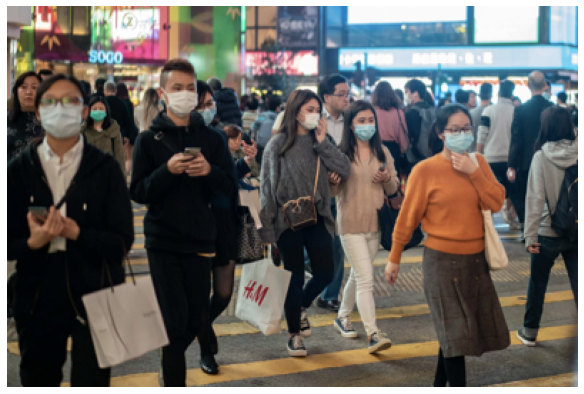

In [ ]:
# Dictionary implementing mappings from labels to colors.
#  'with_mask' : red
#  'without_mask' : green
#  'mask_weared_incorrect' : blue
colors_dict = {
    'with_mask' : (255, 0, 0),
    'without_mask' : (0, 255, 0),
    'mask_weared_incorrect' : (0, 0, 255)
}

# Load a random image of the original dataset.
img, img_path = X[402]

fig = plt.figure(figsize=(15,7))
plt.imshow(np.array(img))
plt.axis('off')

(-0.5, 399.5, 266.5, -0.5)

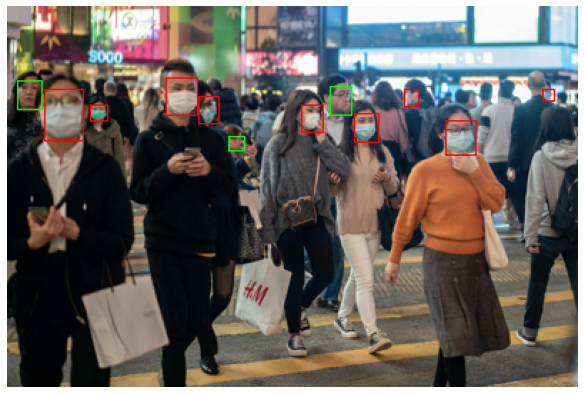

In [ ]:
# Generate the image containing the bounding boxes for each cropped image.
bbimg = drawBoundingBoxes(img.copy(), img_path, df, colors_dict)

fig = plt.figure(figsize=(15,7))
plt.imshow(np.array(bbimg))
plt.axis('off')

In [ ]:
!rm -r cropped/
!mkdir cropped/

rm: cannot remove 'cropped/': No such file or directory


In [ ]:
# Generates cropped images in the ./cropped/ folder.
generateCroppedImages(X, df)

In [ ]:
# Loads images from ./cropped/ folder into Y. The 883 original images have been increased to 4072.
input_dir = './cropped/'
X_cropped = get_images(input_dir)
len(X_cropped)

4072

In [ ]:
# Distribution of the dataset.
print(f"With mask: {len(df.loc[df['labels']=='with_mask'])}")
print(f"Without mask: {len(df.loc[df['labels']=='without_mask'])}")
print(f"With mask worn incorrectly: {len(df.loc[df['labels']=='mask_weared_incorrect'])}")

With mask: 3232
Without mask: 717
With mask worn incorrectly: 123


In [ ]:
# Example of showing the cropped images from the example photo , resized to (64,64) and their labels.
print(img_path)
df_example = df.loc[df['original_filenames']==img_path.replace('./images/', '')]
df_example

./images/maksssksksss460.png


,original_filenames,filenames,xmins,xmaxs,ymins,ymaxs,labels
1896,maksssksksss460.png,maksssksksss460_00.png,7,24,52,72,without_mask
1897,maksssksksss460.png,maksssksksss460_01.png,26,53,58,94,with_mask
1898,maksssksksss460.png,maksssksksss460_02.png,58,70,69,80,with_mask
1899,maksssksksss460.png,maksssksksss460_03.png,111,133,50,76,with_mask
1900,maksssksksss460.png,maksssksksss460_04.png,134,148,63,82,with_mask
1901,maksssksksss460.png,maksssksksss460_05.png,206,221,69,88,with_mask
1902,maksssksksss460.png,maksssksksss460_06.png,226,241,56,76,without_mask
1903,maksssksksss460.png,maksssksksss460_07.png,243,260,75,95,with_mask
1904,maksssksksss460.png,maksssksksss460_08.png,307,328,80,104,with_mask
1905,maksssksksss460.png,maksssksksss460_09.png,155,166,91,101,without_mask


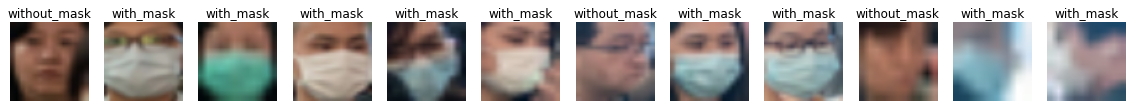

In [ ]:
# Shows cropped images from the example image and their corresponding labels.
indices = df_example.index.values.tolist()
start_index = indices[0]

fig, axs = plt.subplots(1, len(indices), figsize=(20,10))

for i in range(len(indices)):
  test_img, test_path = X_cropped[i+start_index]
  axs[i].imshow(np.array(cv2.resize(test_img, (64,64))))
  axs[i].axis('off')
  axs[i].title.set_text(df['labels'][i+start_index])

# Development of a neural network

After cropping the images and resizing them to (64,64,3), we will develop a CNN to classify a cropped image into one of the three categories ('with mask', 'without_mask', 'mask_weared_incorrect'). 

A typical architecture found in a lot of Classification CNNs will be used which consists of:
* Convolution - MaxPooling Blocks
* A classifier consisting of 2 layers of FC neurons with the ReLU activation function and dropout layers in between. The final output layer consists of 3 FC neurons with the softmax activation function as we want to interpret the output of the $i$th as the probability of having output the class $ci$.


During our tests we tested different convolution blocks and different configurations (number of hidden layers and number of neurons in each layer) of the dense classifier.
The Convolution - MaxPooling Blocks we tested were:
* A Block consisting of two consecutive Convolution - BatchNormalization - Activation - Dropout operations. After these operations, a 2*2 MaxPooling is performed. (convBlock)
* A simpler block similar to the previous, with only 1 Convolution operation. (simplerConvBlock)
* A Block inspired by the Residual Blocks of ResNet.


After our several tests, the CNN with the convBlock and the residual Block overfitted our dataset, yielding accuracies on the train set in the range of $98-99\%$ and in the validation set in the range of $90-92\%$. We found that the simpler convBlock didn't overfit as much and that was the one we used in the final submission.

The architecture of the model we used can be described as:
* simplerConvBlock with 16 filters and Dropout Rate of 0.3.
* simplerConvBlock with 32 filters and Dropout Rate of 0.3.
* simplerConvBlock with 64 filters and Dropout Rate of 0.3.
* Flattening from 2-D to 1-D.
* 1 layer of 16 FC neurons with a Dropout Layer with rate 0.4.
* Output layer of 3 neurons with the softmax activation function.

\\
Furthermore, the dataset is skewed towards the class 'with_mask', with this specific class having $\approx 80\%$ of the total samples. The class with the incorrectly worn mask has only $\approx 3\%$ of the total samples.

We tried an augmentation pipeline using the albumentations python library on the train set, trying to increase the number of samples in the two classes which had the minority in the number of samples. This technique gave marginally better results in some cases.


\\
In order to be more unbiased towards the dataset, we k-folded the original dataset to 4 folds. We used 1 fold for the validation set and the remaining 3 as the train set. We repeated this procedure 4 times and we will choose either the architecture with no augmented data or the architecture with the augmented data based on the performance on the validation sets. Then, we will train a model using the entire dataset as the train set an the model which performs best on the validation set and doesn't overfit as much in the given train set.

\\
We also used some callbacks from the keras library to:
* Lower the learning rate if the validation loss stops decreasing for a number of epochs. This enables us to make smaller movements to try to find the true minimum of the loss function.
* Stops the training if the validation loss stops decreasing for a number of epochs.
* Save the models which output the best validation accuracy. At the end of training, we will load the best model from each k-fold, make an evaluation on the train and validation set and then decide which model performs best in the validation set.

In [ ]:
def convBlock(input, num_filters, dropout_rate, filter_size=(3,3)):
  # Convolution Block with 2 convolution operations.
  
  x = l.Conv2D(num_filters, kernel_size=filter_size, padding='same')(input)
  x = l.BatchNormalization()(x)
  x = l.Activation("relu")(x)
  x = l.Dropout(dropout_rate)(x)

  x = l.Conv2D(num_filters, kernel_size=filter_size, padding='same')(x)
  x = l.BatchNormalization()(x)
  x = l.Activation("relu")(x)
  x = l.Dropout(dropout_rate)(x)

  x = l.MaxPooling2D((2,2))(x)
  return x

In [ ]:
def simplerconvBlock(input, num_filters, dropout_rate, filter_size=(3,3)):
  # Simpler convolution block
  x = l.Conv2D(num_filters, kernel_size=filter_size, padding='same')(input)
  x = l.BatchNormalization()(x)
  x = l.Activation("relu")(x)
  x = l.Dropout(dropout_rate)(x)

 
  x = l.MaxPooling2D((2,2))(x)
  return x

In [ ]:
# Resizes photos to (64,64) and normalizes them.
X = np.array([np.array(cv2.resize(img, (64,64))) for img, _ in X_cropped])
X_norm = X / 255.0

In [ ]:
# Mapping labels to 0, 1, 2
output_dict = {
    'with_mask' : 0,
    'without_mask' : 1,
    'mask_weared_incorrect' : 2
}

labels_df = df['labels'].tolist()
labels = np.array([output_dict.get(label) for label in labels_df])
labels

array([1, 0, 1, ..., 0, 2, 1])

In [ ]:
def define_model():
  # Definition of the final model we used.
  inputs = tf.keras.Input(shape=(64, 64, 3))

  c1 = simplerconvBlock(inputs, 16, 0.3)
  c2 = simplerconvBlock(c1, 32, 0.3)
  c3 = simplerconvBlock(c2, 64, 0.3)

  fl = l.Flatten()(c3)

  d1 = l.Dense(16)(fl)
  d1 = l.Dropout(0.4)(d1)
  outputs = l.Dense(3,activation='softmax')(d1)

  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

In [ ]:
# K-folding on the original dataset, with no augmenting, keeping 1/4 as the validation and 3/4 as the train set. 
# We will save the best model and then load it to make assessments on the validation set.


kfold = KFold(n_splits=4, shuffle=True, random_state=42)
k = 1 

loss_train_noaug = []
acc_train_noaug = []
loss_val_noaug = []
acc_val_noaug = []

histories_noaug = []


for train, val in kfold.split(X, labels):
    print(k)


    # Extract the specific rows from X and y vectors for train and validation datasets.
    X_train = np.take(X, train, axis=0)

    X_val = np.take(X, val, axis=0)
    y_train = np.take(labels, train)
    y_val = np.take(labels, val)

    model = define_model()

    callbacks = [
            tf.keras.callbacks.ModelCheckpoint(f'./models/model_noaug_{k}.h5', verbose=1, save_best_only=True),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15),
            tf.keras.callbacks.ReduceLROnPlateau(
                  monitor="val_loss",
                  factor = 0.1,
                  patience =10,
                  min_lr = 1e-5)]

    results = model.fit(X_train,
      y_train,
	    batch_size=16, 
	    epochs=50, 
	    shuffle=True, 
	    validation_data=(X_val, y_val),
			callbacks = callbacks)
    
    histories_noaug.append(results)
    
    model = m.load_model(f'./models/model_noaug_{k}.h5')
   
    loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
    loss_train_noaug.append(loss)
    acc_train_noaug.append(accuracy)
    
    loss, accuracy = model.evaluate(X_val, y_val, verbose=False)
    loss_val_noaug.append(loss)
    acc_val_noaug.append(accuracy)

    k += 1

1
Epoch 1/50
191/191 [==============================] - ETA: 0s - loss: 0.6656 - accuracy: 0.8874
Epoch 1: val_loss improved from inf to 0.32391, saving model to ./models/model_noaug_1.h5
191/191 [==============================] - 12s 13ms/step - loss: 0.6656 - accuracy: 0.8874 - val_loss: 0.3239 - val_accuracy: 0.8978 - lr: 0.0010
Epoch 2/50
187/191 [============================>.] - ETA: 0s - loss: 0.4165 - accuracy: 0.9134
Epoch 2: val_loss did not improve from 0.32391
191/191 [==============================] - 2s 10ms/step - loss: 0.4157 - accuracy: 0.9139 - val_loss: 0.4404 - val_accuracy: 0.8713 - lr: 0.0010
Epoch 3/50
186/191 [============================>.] - ETA: 0s - loss: 0.3741 - accuracy: 0.9237
Epoch 3: val_loss did not improve from 0.32391
191/191 [==============================] - 2s 10ms/step - loss: 0.3732 - accuracy: 0.9227 - val_loss: 0.5324 - val_accuracy: 0.8163 - lr: 0.0010
Epoch 4/50
189/191 [============================>.] - ETA: 0s - loss: 0.2812 - accuracy: 0

In [ ]:
import albumentations as A
from tqdm import tqdm

# An augmentation pipeline consisting of different image transformations.
aug = A.Compose([
		A.HorizontalFlip(p=0.5),
		# A.VerticalFlip(p=0.5),
		# A.RandomRotate90(p=0.5),
		A.OneOf([
		  A.RandomBrightnessContrast(p=0.7),    
		  A.RandomGamma(p=0.7)]),
		A.OneOf([
		  A.ElasticTransform(p=0.7,alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
		  A.GridDistortion(p=0.7)
		])
	])

def augment(aug, rounds, X_train, y_train):
  """
    Loop 'rounds' times on the train set, augmenting each photo on the train set at each pass.
  """
  aug_train_x = []
  aug_train_y = []
  
  for i in tqdm(range(len(X_train))):
    aug_train_x.append(X_train[i])
    aug_train_y.append(y_train[i])

  for round in range(rounds):
    for i in tqdm(range(len(X_train))):
      augmented = aug(image=X_train[i])
      aug_train_x.append(augmented['image'])
      aug_train_y.append(y_train[i])
  return np.array(aug_train_x), np.array(aug_train_y)


In [ ]:
# K-folding on the original dataset, with augmenting 2 times the 'without mask' class and 5 times the
# 'mask worn incorrectly class' in order to increase their samples. Ae before, we will keep 1/4 of the samples as the validation set,
# which we will not augment  and 3/4 as the train set, which we will augment.
# In this way and by passing a fixed random state on the kfold method, the assessments will be made on the same validation set as before
# We will save the best model and then load it to make assessments on the validation set.

kfold = KFold(n_splits=4, shuffle=True, random_state=42)
k = 1 

loss_train_aug = []
acc_train_aug = []
loss_val_aug = []
acc_val_aug = []

histories_aug = []

for train, val in kfold.split(X, labels):
    print(k)

    # Extract the specific rows from X and y vectors for train and validation datasets.

    X_train = np.take(X, train, axis=0)
    y_train = np.take(labels, train)

    X_val = np.take(X, val, axis=0)
    y_val = np.take(labels, val)

    X_withmask = X_train[y_train==0]
    y_withmask = y_train[y_train==0]

    X_withoutmask = X_train[y_train==1]
    y_withoutmask = y_train[y_train==1]

    X_maskincorrectly = X_train[y_train==2]
    y_maskincorrectly = y_train[y_train==2]

    aug_X_withoutmask, aug_y_withoutmask = augment(aug, 2, X_withoutmask, y_withoutmask)
    aug_X_maskincorrectly, aug_y_maskincorrectly = augment(aug, 5, X_maskincorrectly, y_maskincorrectly)

    aug_X = np.concatenate((X_withmask, aug_X_withoutmask, aug_X_maskincorrectly))
    aug_y = np.concatenate((y_withmask, aug_y_withoutmask, aug_y_maskincorrectly))

    model = define_model()

    callbacks = [
            tf.keras.callbacks.ModelCheckpoint(f'./models/model_aug_{k}.h5', verbose=1, save_best_only=True),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
            tf.keras.callbacks.ReduceLROnPlateau(
                  monitor="val_loss",
                  factor = 0.1,
                  patience =15,
                  min_lr = 1e-5)]

    results = model.fit(aug_X,
      aug_y,
	    batch_size=16, 
	    epochs=50, 
	    shuffle=True, 
	    validation_data=(X_val, y_val),
			callbacks = callbacks)
    
    histories_aug.append(results)
    
   
    model = m.load_model(f'./models/model_aug_{k}.h5')
    
    loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
    loss_train_aug.append(loss)
    acc_train_aug.append(accuracy)
    
    loss, accuracy = model.evaluate(X_val, y_val, verbose=False)
    loss_val_aug.append(loss)
    acc_val_aug.append(accuracy)
    
    k += 1

1


100%|██████████| 90/90 [00:00<00:00, 673.21it/s]


Epoch 1/50
287/287 [==============================] - ETA: 0s - loss: 0.9986 - accuracy: 0.8108
Epoch 1: val_loss improved from inf to 0.28590, saving model to ./models/model_aug_1.h5
287/287 [==============================] - 4s 11ms/step - loss: 0.9986 - accuracy: 0.8108 - val_loss: 0.2859 - val_accuracy: 0.8949 - lr: 0.0010
Epoch 2/50
282/287 [============================>.] - ETA: 0s - loss: 0.5242 - accuracy: 0.8706
Epoch 2: val_loss did not improve from 0.28590
287/287 [==============================] - 3s 10ms/step - loss: 0.5252 - accuracy: 0.8705 - val_loss: 2.0512 - val_accuracy: 0.3605 - lr: 0.0010
Epoch 3/50
287/287 [==============================] - ETA: 0s - loss: 0.4166 - accuracy: 0.8816
Epoch 3: val_loss did not improve from 0.28590
287/287 [==============================] - 3s 10ms/step - loss: 0.4166 - accuracy: 0.8816 - val_loss: 0.2934 - val_accuracy: 0.8910 - lr: 0.0010
Epoch 4/50
283/287 [============================>.] - ETA: 0s - loss: 0.2938 - accuracy: 0.9048

100%|██████████| 85/85 [00:00<00:00, 731.50it/s]


Epoch 1/50
286/286 [==============================] - ETA: 0s - loss: 0.9240 - accuracy: 0.8045
Epoch 1: val_loss improved from inf to 0.21514, saving model to ./models/model_aug_2.h5
286/286 [==============================] - 4s 12ms/step - loss: 0.9240 - accuracy: 0.8045 - val_loss: 0.2151 - val_accuracy: 0.9312 - lr: 0.0010
Epoch 2/50
286/286 [==============================] - ETA: 0s - loss: 0.4885 - accuracy: 0.8646
Epoch 2: val_loss did not improve from 0.21514
286/286 [==============================] - 3s 10ms/step - loss: 0.4885 - accuracy: 0.8646 - val_loss: 0.2459 - val_accuracy: 0.8978 - lr: 0.0010
Epoch 3/50
282/286 [============================>.] - ETA: 0s - loss: 0.3520 - accuracy: 0.8938
Epoch 3: val_loss did not improve from 0.21514
286/286 [==============================] - 3s 10ms/step - loss: 0.3522 - accuracy: 0.8937 - val_loss: 0.2723 - val_accuracy: 0.9008 - lr: 0.0010
Epoch 4/50
284/286 [============================>.] - ETA: 0s - loss: 0.2938 - accuracy: 0.9032

100%|██████████| 101/101 [00:00<00:00, 710.43it/s]


Epoch 1/50
290/290 [==============================] - ETA: 0s - loss: 0.9767 - accuracy: 0.7921
Epoch 1: val_loss improved from inf to 0.32634, saving model to ./models/model_aug_3.h5
290/290 [==============================] - 5s 13ms/step - loss: 0.9767 - accuracy: 0.7921 - val_loss: 0.3263 - val_accuracy: 0.8870 - lr: 0.0010
Epoch 2/50
288/290 [============================>.] - ETA: 0s - loss: 0.4781 - accuracy: 0.8607
Epoch 2: val_loss improved from 0.32634 to 0.20440, saving model to ./models/model_aug_3.h5
290/290 [==============================] - 3s 11ms/step - loss: 0.4773 - accuracy: 0.8608 - val_loss: 0.2044 - val_accuracy: 0.9303 - lr: 0.0010
Epoch 3/50
287/290 [============================>.] - ETA: 0s - loss: 0.3558 - accuracy: 0.8892
Epoch 3: val_loss did not improve from 0.20440
290/290 [==============================] - 3s 11ms/step - loss: 0.3542 - accuracy: 0.8897 - val_loss: 0.4518 - val_accuracy: 0.8183 - lr: 0.0010
Epoch 4/50
286/290 [============================>.

100%|██████████| 93/93 [00:00<00:00, 764.00it/s]


Epoch 1/50
287/287 [==============================] - ETA: 0s - loss: 1.0233 - accuracy: 0.8128
Epoch 1: val_loss improved from inf to 0.25824, saving model to ./models/model_aug_4.h5
287/287 [==============================] - 5s 13ms/step - loss: 1.0233 - accuracy: 0.8128 - val_loss: 0.2582 - val_accuracy: 0.9096 - lr: 0.0010
Epoch 2/50
287/287 [==============================] - ETA: 0s - loss: 0.4583 - accuracy: 0.8834
Epoch 2: val_loss improved from 0.25824 to 0.22493, saving model to ./models/model_aug_4.h5
287/287 [==============================] - 3s 11ms/step - loss: 0.4583 - accuracy: 0.8834 - val_loss: 0.2249 - val_accuracy: 0.9234 - lr: 0.0010
Epoch 3/50
287/287 [==============================] - ETA: 0s - loss: 0.3370 - accuracy: 0.8947
Epoch 3: val_loss did not improve from 0.22493
287/287 [==============================] - 3s 11ms/step - loss: 0.3370 - accuracy: 0.8947 - val_loss: 0.2800 - val_accuracy: 0.9185 - lr: 0.0010
Epoch 4/50
287/287 [==============================

In [ ]:
def plot_history(history, augment):
    """
        Plots accuracy and loss on train and validation on all sets during training.
    """
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='train acc')
    plt.plot(x, val_acc, 'r', label='val acc')
    plt.title(f'Accuracy in train and val set {augment}')
    plt.ylim(0.8, 1.0)
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='train loss')
    plt.plot(x, val_loss, 'r', label='val loss')
    plt.ylim(0.0, 0.7)
    plt.title(f'Loss in train and val set {augment}')
    plt.legend()

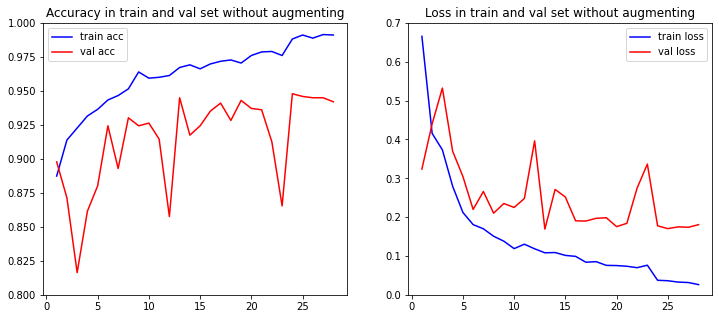

In [ ]:
plot_history(histories_noaug[0], 'without augmenting')

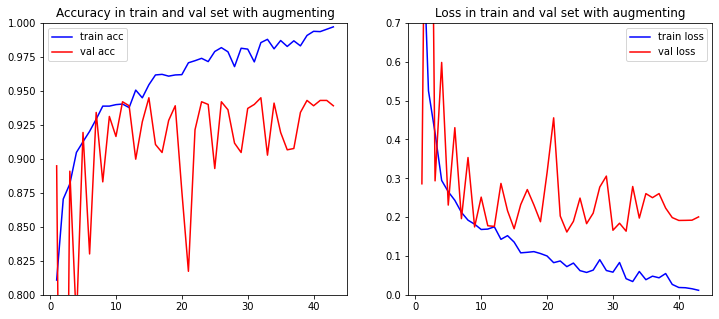

In [ ]:
plot_history(histories_aug[0], 'with augmenting')

From 2 example history curves from the 4-folded tests we performed we can see that the augmentation led to unstable curves, especially in the validation set. Furthermore, it didn't improve the overfitting issue, in fact it made it worse. If we consider this with the results we provide next, we decided to use the no augmentation model, trained with the entire dataset for our submission.

In [ ]:
print("With no augmenting")
print(f"Loss on train set at each fold: {loss_train_noaug}")
print(f"Acc on train set at each fold: {acc_train_noaug}")
print(f"Loss on val set at each fold: {loss_val_noaug}")
print(f"Acc on val set at each fold: {acc_val_noaug}")

With no augmenting
Loss on train set at each fold: [0.07726781070232391, 0.10814119875431061, 0.09156300872564316, 0.10929393768310547]
Acc on train set at each fold: [0.974787175655365, 0.9643090963363647, 0.9741322994232178, 0.9675834774971008]
Loss on val set at each fold: [0.17074230313301086, 0.16860544681549072, 0.13527098298072815, 0.17161627113819122]
Acc on val set at each fold: [0.943025529384613, 0.9420432448387146, 0.9666011929512024, 0.943025529384613]


In [ ]:
print("With no augmenting")
print(f"Average loss on train set: {np.mean(loss_train_noaug)}")
print(f"Average acc on train set: {np.mean(acc_train_noaug)}")
print(f"Average loss on val set: {np.mean(loss_val_noaug)}")
print(f"Average acc on val set: {np.mean(acc_val_noaug)}")

With no augmenting
Average loss on train set: 0.08562998846173286
Average acc on train set: 0.973722979426384
Average loss on val set: 0.162491574883461
Average acc on val set: 0.9513752311468124


In [ ]:
print("With augmenting")
print(f"Loss on train set at each fold: {loss_train_aug}")
print(f"Acc on train set at each fold: {acc_train_aug}")
print(f"Loss on val set at each fold: {loss_val_aug}")
print(f"Acc on val set at each fold: {acc_val_aug}")

With augmenting
Loss on train set at each fold: [0.07640467584133148, 0.11202844232320786, 0.09758085757493973, 0.08105706423521042]
Acc on train set at each fold: [0.9833005666732788, 0.9633268117904663, 0.9646365642547607, 0.9708579182624817]
Loss on val set at each fold: [0.16167916357517242, 0.17116285860538483, 0.1541101336479187, 0.1956072449684143]
Acc on val set at each fold: [0.9420432448387146, 0.9420432448387146, 0.9548133611679077, 0.9390962719917297]


In [ ]:
print("With augmenting")
print(f"Average loss on train set: {np.mean(loss_train_aug)}")
print(f"Average acc on train set: {np.mean(acc_train_aug)}")
print(f"Average loss on val set: {np.mean(loss_val_aug)}")
print(f"Average acc on val set: {np.mean(acc_val_aug)}")

With augmenting
Average loss on train set: 0.09176775999367237
Average acc on train set: 0.9705304652452469
Average loss on val set: 0.17063985019922256
Average acc on val set: 0.9444990307092667


After examining the losses and accuracies on the validation sets, we decided that the no augmentation is the best configuration of model - data for the specific dataset. The average loss/accuracy on the validation set across 4 folds is better if we take into account the reported accuracy on the train set.
Generally, we can say that the behavior is the same, if we consider the innate randomness of the neural networks and the data.

There is a small overfitting happening, which may be owed to the distribution of the dataset images and the abundance of photos of people wearing masks.

So, we will use the entire dataset as the train set without augmenting it, saving the model as a .h5 file and submitting it with our deliverables.

In [ ]:
model = define_model()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(f'./models/model_noaug_FINAL.h5', verbose=1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15),
    tf.keras.callbacks.ReduceLROnPlateau(
                  monitor="val_loss",
                  factor = 0.1,
                  patience =10,
                  min_lr = 1e-5)]

results = model.fit(X,
      labels,
	    batch_size=16, 
	    epochs=50, 
	    shuffle=True, 
	    validation_data=(X_val, y_val),
			callbacks = callbacks)

Epoch 1/50
255/255 [==============================] - ETA: 0s - loss: 0.5062 - accuracy: 0.8934
Epoch 1: val_loss improved from inf to 0.20622, saving model to ./models/model_noaug_FINAL.h5
255/255 [==============================] - 4s 13ms/step - loss: 0.5062 - accuracy: 0.8934 - val_loss: 0.2062 - val_accuracy: 0.9381 - lr: 0.0010
Epoch 2/50
252/255 [============================>.] - ETA: 0s - loss: 0.2839 - accuracy: 0.9214
Epoch 2: val_loss did not improve from 0.20622
255/255 [==============================] - 3s 10ms/step - loss: 0.2825 - accuracy: 0.9219 - val_loss: 0.2376 - val_accuracy: 0.9175 - lr: 0.0010
Epoch 3/50
251/255 [============================>.] - ETA: 0s - loss: 0.2055 - accuracy: 0.9338
Epoch 3: val_loss did not improve from 0.20622
255/255 [==============================] - 3s 10ms/step - loss: 0.2042 - accuracy: 0.9339 - val_loss: 0.2230 - val_accuracy: 0.9361 - lr: 0.0010
Epoch 4/50
254/255 [============================>.] - ETA: 0s - loss: 0.1903 - accuracy: 